<a href="https://colab.research.google.com/github/HakkiAkut/ai-ml-algorithms/blob/master/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Generative Adversarial Network for converting dog images into cat images. The dataset is from https://www.kaggle.com/c/dogs-vs-cats/rules,

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [1]:
%cd /content/drive/MyDrive/ML/gan/

/content/drive/MyDrive/ML/gan


I have two zip files in gdrive which named train.zip and test1.zip, I unzip these two zip files.

In [ ]:
!unzip /content/drive/MyDrive/ML/gan/train.zip

In [ ]:
!unzip /content/drive/MyDrive/ML/gan/test1.zip

Since cats and dogs images are in same file, I created two directories for each.

In [ ]:
!mkdir /content/drive/MyDrive/ML/gan/train/cats
!mkdir /content/drive/MyDrive/ML/gan/train/dogs

Moved images to the created directories.

In [ ]:
!mv /content/drive/MyDrive/ML/gan/train/cat.{0..12499}.jpg /content/drive/MyDrive/ML/gan/train/cats

In [ ]:
!mv /content/drive/MyDrive/ML/gan/train/dog.{0..12499}.jpg /content/drive/MyDrive/ML/gan/train/dogs

In [ ]:
import tensorflow 
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
cat_data = image_dataset_from_directory(
        '/content/drive/MyDrive/ML/gan/train/cat',
        batch_size=1,)

dog_data = image_dataset_from_directory(
        '/content/drive/MyDrive/ML/gan/train/dog',
        batch_size=1,)

In [ ]:
def normalize(image,label):
  image = tensorflow.cast(image, tensorflow.float32)
  image = (image / 255) 
  return image

In [ ]:
cats = cat_data.cache().map(normalize).shuffle(100)
dogs = dog_data.cache().map(normalize).shuffle(100)

In [ ]:
cat_generator = pix2pix.unet_generator(3, norm_type='instancenorm') # dog to cat
dog_generator = pix2pix.unet_generator(3, norm_type='instancenorm') # cat to dog

dog_discriminator = pix2pix.discriminator(norm_type='instancenorm', target=False)
cat_discriminator = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
loss = BinaryCrossentropy(from_logits=True)

def generator_loss(generated):
  return loss(tensorflow.ones_like(generated), generated)

def discriminator_loss(image, generated):
  image_loss = generator_loss(image)
  generated_loss = loss(tensorflow.zeros_like(generated), generated)
  total_loss = (image_loss + generated_loss) / 2.0
  return total_loss

In [ ]:
def cycle_loss(image, cycle):
  loss_cycle = tensorflow.reduce_mean(tensorflow.abs(image - cycle))
  return 10 * loss_cycle

def identity_loss(real_image, same_image):
  loss = cycle_loss(real_image,same_image)
  return loss / 2.0

In [ ]:
generator_g_optimizer = tensorflow.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tensorflow.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tensorflow.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tensorflow.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
@tensorflow.function
def train_step(real_x, real_y):
  with tensorflow.GradientTape(persistent=True) as tape:

    fake_y = cat_generator(real_x, training=True)
    cycled_x = dog_generator(fake_y, training=True)

    fake_x = dog_generator(real_y, training=True)
    cycled_y = cat_generator(fake_x, training=True)

    same_x = dog_generator(real_x, training=True)
    same_y = cat_generator(real_y, training=True)

    disc_real_x = dog_discriminator(real_x, training=True)
    disc_real_y = cat_discriminator(real_y, training=True)

    disc_fake_x = dog_discriminator(fake_x, training=True)
    disc_fake_y = cat_discriminator(fake_y, training=True)

    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        cat_generator.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        dog_generator.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            dog_discriminator.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            cat_discriminator.trainable_variables)
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            cat_generator.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            dog_generator.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                dog_discriminator.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                cat_discriminator.trainable_variables))

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display = [test_input[0], prediction[0]]
  title = ['Input', 'Generated ']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
for epoch in range(5):
  print(epoch)
  #start = time.time()
  n = 0
  for image_x, image_y in tensorflow.data.Dataset.zip((cats, dogs)):
    train_step(image_x, image_y)
    print('x')

In [ ]:
dog = next(iter(dogs))

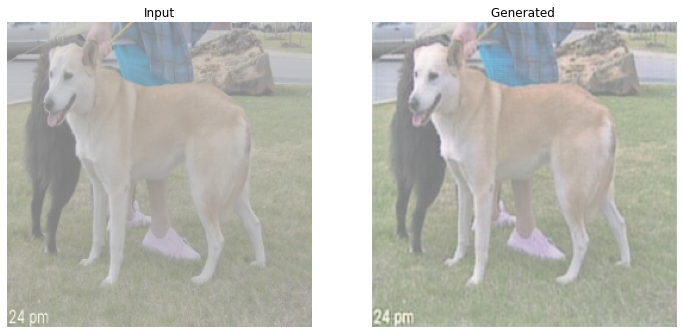

In [ ]:
generate_images(cat_generator, dog)

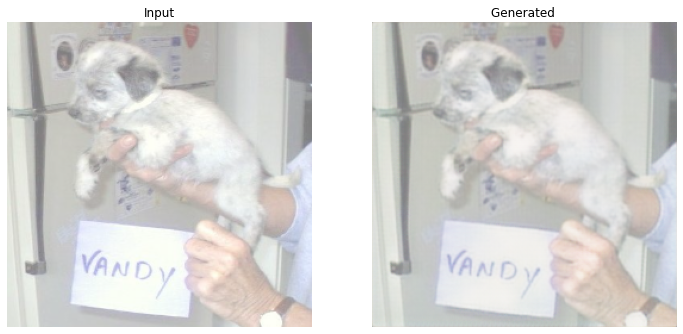

In [ ]:
generate_images(cat_generator, dog)

In this assignment, I used CycleGAN because its used for image-to-iamge translations. 

The library I used in this assignment is tensorflow and I used pix2pix model from tensorflow too.

I found out these network examples and used them my baseline https://www.tensorflow.org/tutorials/generative/cyclegan https://keras.io/examples/generative/cyclegan/

Firstly I imported my dataset in a suitable format, and mapped them while normilizing them in [-1,1] format.  

In CycleGAN, firstly I created generator and discriminator vith pix2pix model. Then I created a loss function(BinaryCrossentropy) with tensorflow. With this loss function I calculated discriminator and generator losses. Also created an cycle loss and identity loss. Lastly I used train function from tensorflow CycleGAN (from first link).

I had to reduced my dataset since it trains 12+ hours for one epoch.

The model makes some changes on the image yet its not significant. It didn't work out because it trained only 5 times. With a proper epoch it could turn out to be a good model.